In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [9]:
data0 = pd.read_csv('./BTC_1h_profit_relative.csv')

data0['datetime'] = pd.to_datetime(data0['datetime'])
data0 = data0.set_index('datetime')

data0

,profit_relative
datetime,
2021-01-01 00:00:00,0.986022
2021-01-01 01:00:00,0.989286
2021-01-01 02:00:00,0.990580
2021-01-01 03:00:00,0.996278
2021-01-01 04:00:00,0.995233
...,...
2025-06-07 19:00:00,0.950170
2025-06-07 20:00:00,0.956374
2025-06-07 21:00:00,0.958932


In [10]:
df = data0.copy()

df_half_hourly = df.resample('30min').mean()

df_hourly = df.resample('1h').mean()

df_daily = df.resample('1D').mean()

df_weekly = df.resample('1W').mean()

In [11]:
df_daily

,profit_relative
datetime,
2021-01-01,0.994602
2021-01-02,0.994629
2021-01-03,0.996292
2021-01-04,0.982823
2021-01-05,0.971780
...,...
2025-06-03,0.953907
2025-06-04,0.951870
2025-06-05,0.939643


In [12]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# 1. 提取原始序列
raw_series = df_daily['profit_relative']

# 2. 8/2 split
split_idx = int(len(raw_series) * 0.8)
train_series = raw_series.iloc[:split_idx]   # 前 80% 作为训练集
test_series = raw_series.iloc[split_idx:]    # 后 20% 作为测试集

# 3. 定义 ADF 检验函数
def adf_test(series, title=""):
    print(f"\n=== {title} ADF 检验 ===")
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('临界值:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    if result[1] < 0.05:
        print("序列平稳")
    else:
        print("序列非平稳")

# 4. 检验训练集（原始）
adf_test(train_series, "训练集（原始）")

# 5. 对训练集做一阶差分
train_diff = train_series.diff().dropna()

# 6. 检验训练集（一阶差分后）
adf_test(train_diff, "训练集（一阶差分后）")


=== 训练集（原始） ADF 检验 ===
ADF Statistic: -2.767350
p-value: 0.063091
临界值:
  1%: -3.435
  5%: -2.864
  10%: -2.568
序列非平稳

=== 训练集（一阶差分后） ADF 检验 ===
ADF Statistic: -25.810859
p-value: 0.000000
临界值:
  1%: -3.435
  5%: -2.864
  10%: -2.568
序列平稳


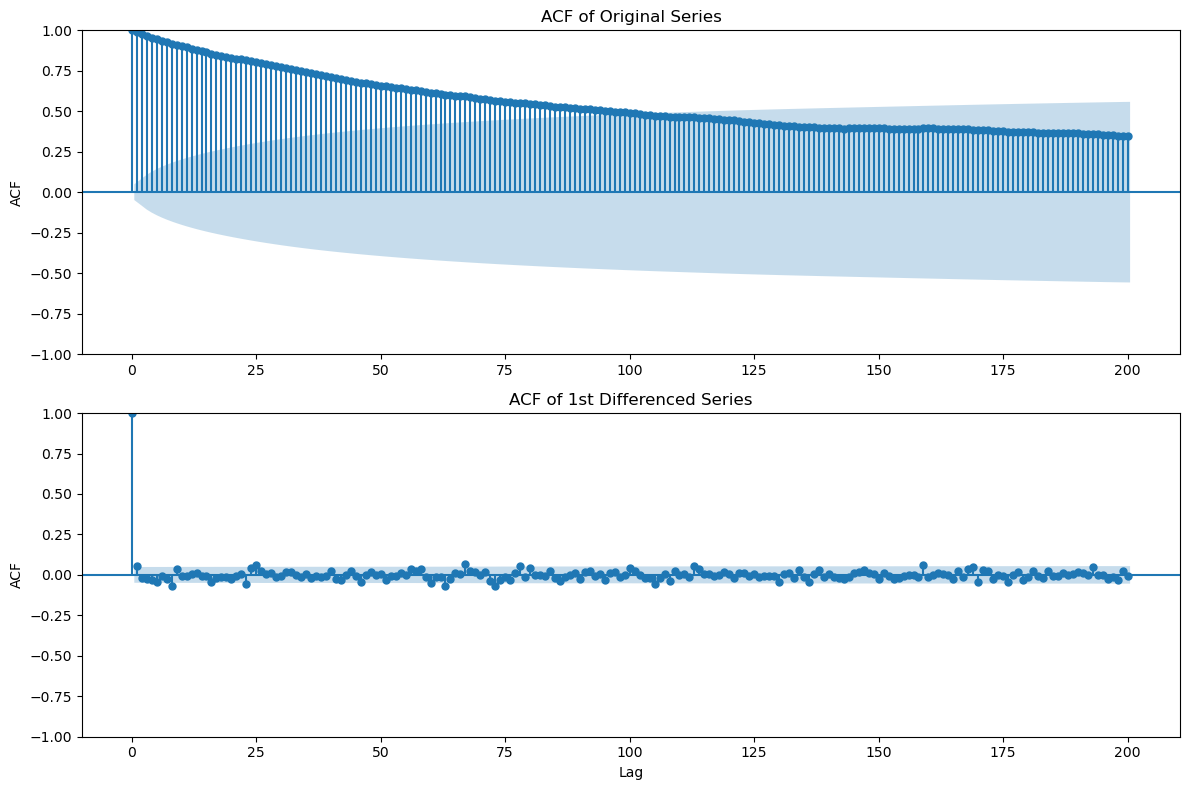

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# 1. 提取原始序列
raw_series = df_daily['profit_relative']

# 2. 一阶差分
diff_series = raw_series.diff().dropna()

# 3. 绘制两个 ACF 图（并排）
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 原始序列 ACF
plot_acf(raw_series, lags=200, ax=axes[0], title='ACF of Original Series')
axes[0].set_ylabel('ACF')

# 一阶差分序列 ACF
plot_acf(diff_series, lags=200, ax=axes[1], title='ACF of 1st Differenced Series')
axes[1].set_ylabel('ACF')
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

___

## 动态训练（在最开始的0.8训练集确定并固定外部超参数p/d/q，每次使用真实数据向前预测一个数据点，不断扩大训练集）

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

# 假设 df_2023_onward_daily 是一个 pandas Series，索引为日期
y = raw_series

# 8/2 split
split_idx = int(len(y) * 0.8)
y_train_initial = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

def grid_search_arima(y_train, p_values, d_values, q_values):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p, d, q in product(p_values, d_values, q_values):
        model = ARIMA(y_train, order=(p, d, q))
        fitted = model.fit()
        aic = fitted.aic
        if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
                best_model = fitted
    return best_order, best_aic, best_model

# 搜索范围
p_values = range(0, 6)  # 0-5
d_values = [1]  # 1
q_values = range(0, 6)  # 0-5

best_order, best_aic, _ = grid_search_arima(y_train_initial, p_values, d_values, q_values)
print(f"Best order: {best_order}, AIC: {best_aic}")

def rolling_forecast(y_train_initial, y_test, order):
    history = y_train_initial.tolist()
    predictions = []

    for i in range(len(y_test)):
        # 用当前 history 拟合模型
        model = ARIMA(history, order=order)
        fitted = model.fit()
        
        # 预测下一步（h=1）
        y_pred = fitted.forecast(steps=1)[0]
        predictions.append(y_pred)
        
        # 将真实值加入 history（滚动）
        history.append(y_test.iloc[i])
        
    return np.array(predictions)

def mase(y_true, y_pred, y_train):
    """Mean Absolute Scaled Error"""
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_train.diff().dropna()))
    return mae_model / mae_naive if mae_naive != 0 else np.nan

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error (original definition)"""
    return np.mean(np.abs((y_true - y_pred) / y_true))

def compute_metrics(y_true, y_pred, y_train):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape_val = mape(y_true, y_pred)
    mase_val = mase(y_true, y_pred, y_train)
    return rmse, mae, mape_val, mase_val

def fast_forecast(y_train, y_test, order):
    model = ARIMA(y_train, order=order)
    fitted = model.fit()
    
    start = len(y_train)
    end = len(y_train) + len(y_test) - 1
    y_pred = fitted.predict(start=start, end=end, dynamic=True)
    
    return y_pred, fitted.aic, fitted.bic


# 执行滚动预测
y_pred_rolling = rolling_forecast(y_train_initial, y_test, best_order)

# 确保长度一致
y_true = y_test.values
y_pred = y_pred_rolling
y_train_full = y_train_initial  # 用于 MASE 的 naive forecast

# 计算指标
rmse, mae, mape_val, mase_val = compute_metrics(y_true, y_pred, y_train_full)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape_val:.4f}")
print(f"MASE: {mase_val:.4f}")


Best order: (3, 1, 4), AIC: -6525.427749215527
RMSE: 0.0222
MAE: 0.0160
MAPE: 0.0186
MASE: 1.1279


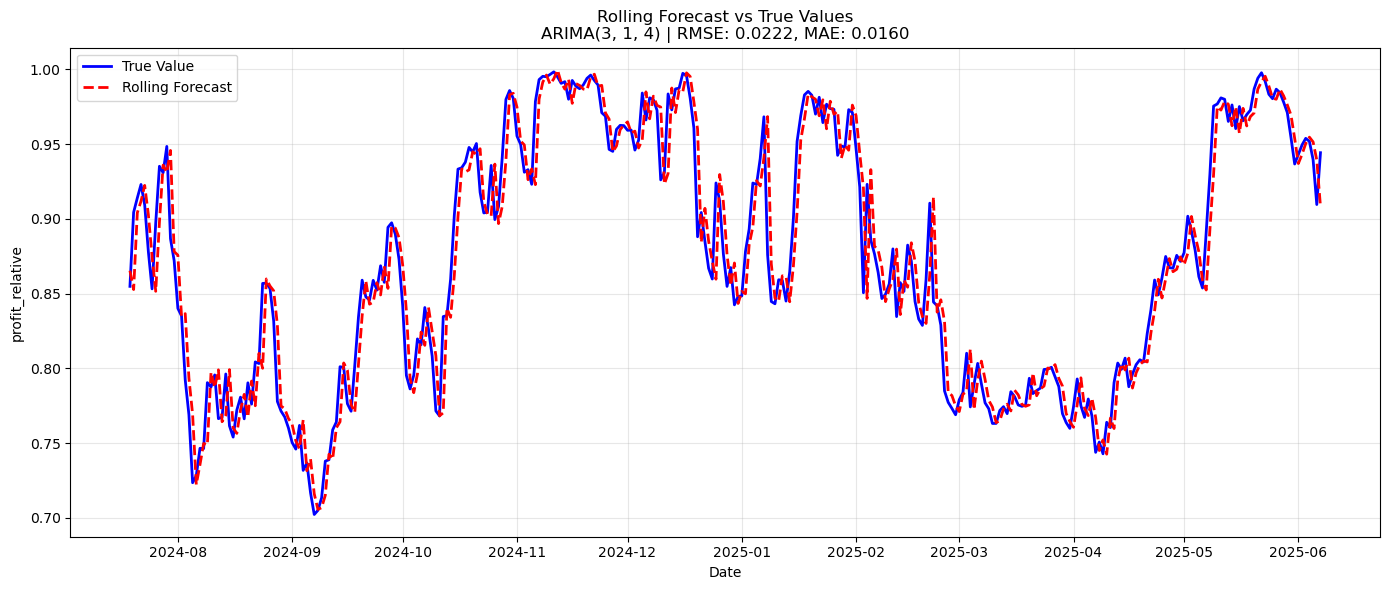

In [15]:
import matplotlib.pyplot as plt

# 创建绘图
plt.figure(figsize=(14, 6))

# 画真实值（测试集部分）
plt.plot(y_test.index, y_true, label='True Value', color='blue', linewidth=2)

# 画预测值
plt.plot(y_test.index, y_pred, label='Rolling Forecast', color='red', linestyle='--', linewidth=2)

# 添加标题和标签
plt.title(f'Rolling Forecast vs True Values\nARIMA{best_order} | RMSE: {rmse:.4f}, MAE: {mae:.4f}')
plt.xlabel('Date')
plt.ylabel('profit_relative')
plt.legend()
plt.grid(True, alpha=0.3)

# 显示图形
plt.tight_layout()
plt.show()

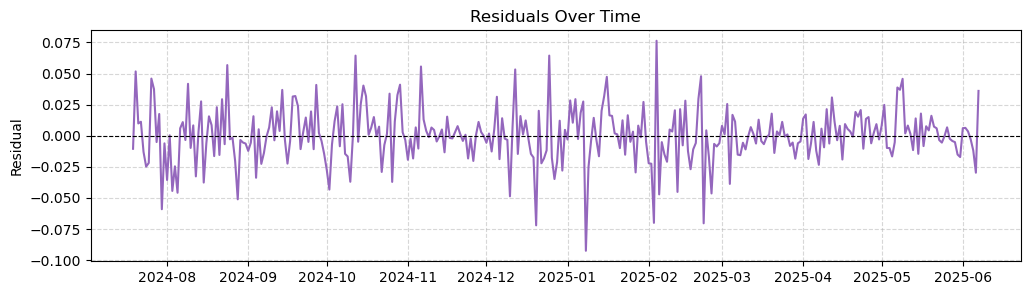

In [16]:
## 残差分析图
residuals = y_true - y_pred_rolling

plt.figure(figsize=(12, 3))
plt.plot(y_test.index, residuals, color='tab:purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Residuals Over Time')
plt.ylabel('Residual')
plt.grid(True, linestyle='--', alpha=0.5)

Text(0.5, 1.0, 'ACF of Residuals')

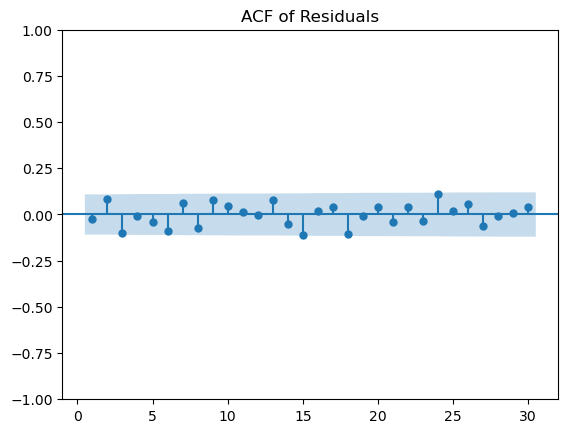

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=30, zero=False)  # zero=False 不画 lag=0
plt.title('ACF of Residuals')

In [18]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box on residuals
ljung_res = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
ljung_res.columns = [f"{col}_res" for col in ljung_res.columns]  # 加前缀区分

# Ljung-Box on squared residuals
residuals_sq = np.square(residuals)
ljung_res_sq = acorr_ljungbox(residuals_sq, lags=[10, 20, 30], return_df=True)
ljung_res_sq.columns = [f"{col}_res_sq" for col in ljung_res_sq.columns]  # 加前缀区分

# 合并成一个 dataframe
combined = pd.concat([ljung_res, ljung_res_sq], axis=1)

combined

,lb_stat_res,lb_pvalue_res,lb_stat_res_sq,lb_pvalue_res_sq
10,14.642375,0.145654,16.002195,0.099570
20,27.436517,0.123424,40.494754,0.004323
30,36.619212,0.188499,67.786043,0.000095


___